<a href="https://colab.research.google.com/github/amedyukhina/biomassters/blob/main/biomassters_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%writefile requirements.txt

pandas==1.3.5
scikit-learn==1.0.2
tqdm==4.64.0
numpy==1.21.6
torch==1.12.1
torchvision==0.13.1
scikit-image==0.18.3
matplotlib==3.2.2
rasterio==1.2.0
boto3==1.26.16
pytorch_lightning
segmentation_models_pytorch
wandb

Overwriting requirements.txt


In [2]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
import os
import rasterio
import pandas as pd
from tqdm import tqdm
import numpy as np

import boto3
from botocore import UNSIGNED
from botocore.config import Config

from cachetools import cached, TTLCache

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchvision.transforms import Compose, Normalize
import torch.nn.functional as F
import segmentation_models_pytorch as smp
import os
from torchvision.io import read_image
from torchvision import transforms
import rasterio
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import pytorch_lightning as pl
import warnings
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
import shutil
from scipy import ndimage
import wandb

# Our rasters contain no geolocation info, so silence this warning from rasterio
warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)

In [4]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
with open('gdrive/MyDrive/Personal/wandb_apikey') as f:
    key = f.read()

os.environ['WANDB_API_KEY'] = key.rstrip('\n')

### Prepare list of chip IDs

In [6]:
feature_path = 'gdrive/MyDrive/biomassters/info/features_metadata.csv'
train_img_dir = 'train_features'
test_img_dir = 'test_features'
label_dir = 'train_agbm'
output_dir = 'predicted'
model_checkpoint_path = 'gdrive/MyDrive/biomassters/models/'

In [7]:
df = pd.read_csv(feature_path)

In [8]:
df_pred = df[df['split'] == 'test'].reset_index(drop=True)
pred_ids = np.unique(df_pred['chip_id'])
len(df_pred), len(pred_ids)

(63348, 2773)

In [9]:
df = df[df['split'] == 'train'].reset_index(drop=True)
all_ids = np.unique(df['chip_id'])
len(df), len(all_ids)

(189078, 8689)

In [10]:
np.random.seed(42)
np.random.shuffle(all_ids)

In [11]:
train_ids = all_ids[:500]
val_ids = all_ids[500:550]

### Set up data loading

In [12]:
BUCKET_NAME = 'drivendata-competition-biomassters-public-us'
os.environ["AWS_NO_SIGN_REQUEST"] = 'YES'
s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))

In [13]:
cache = TTLCache(maxsize=1000, ttl=86400)

In [14]:
@cached(cache)
def get_image(fn):
  obj = s3.get_object(Bucket=BUCKET_NAME, Key=fn)
  with rasterio.open(obj['Body']) as src:
    img = src.read()
  return img

### Calculate mean and std of the dataset

In [15]:
imgs = np.array([get_image(os.path.join(train_img_dir, 
                                        rf"{chip_id}_S2_10.tif"))[:10].astype(np.float32)
for chip_id in tqdm(train_ids)])

  0%|          | 0/500 [00:00<?, ?it/s]

In [16]:
imgs.shape

(500, 10, 256, 256)

In [17]:
MEANS = np.array([imgs[:,i].mean() for i in range(imgs.shape[1])])
STDS = np.array([imgs[j,i].std() for j in range(imgs.shape[0]) 
  for i in range(imgs.shape[1])]).reshape((imgs.shape[:2])).mean(0)
MEANS, STDS

(array([ 380.4021 ,  535.0182 ,  421.57675,  817.7593 , 1889.2316 ,
        2205.7764 , 2321.24   , 2394.7937 , 1272.0664 ,  702.64954],
       dtype=float32),
 array([319.6245 , 349.22687, 364.47675, 454.4305 , 777.2495 , 899.8386 ,
        970.10986, 952.7745 , 607.3759 , 443.7978 ], dtype=float32))

### Define a dataset

In [18]:
class SentinelDataset2(Dataset):
    def __init__(self, chip_ids, img_dir, label_dir=None, 
                 transform=None):
        self.chip_ids = chip_ids
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.chip_ids)

    def __getitem__(self, idx):
        image = get_image(os.path.join(self.img_dir, 
                                       rf"{self.chip_ids[idx]}_S2_10.tif"))
        image = torch.tensor(image.astype(np.float32)[:10])
        image = (image - 
                 torch.tensor(MEANS).unsqueeze(1).unsqueeze(1))/torch.tensor(STDS).unsqueeze(1).unsqueeze(1)
        
        if self.label_dir is not None:
            label = get_image(os.path.join(self.label_dir, 
                                           rf"{self.chip_ids[idx]}_agbm.tif"))
            label = ndimage.median_filter(label[0], 3)
            label = torch.tensor(label.astype(np.float32)).unsqueeze(0)
        else:
            label = None

        
        if self.transform:
            image = self.transform(torch.concat([image, label]))
            label = image[-1:]
            image = image[:-1]
            
        return image, label

In [19]:
train_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(degrees=180)
    ])


In [20]:
train_ds = SentinelDataset2(train_ids, train_img_dir, label_dir, 
                            transform=train_transforms
                            )
val_ds = SentinelDataset2(val_ids, train_img_dir, label_dir)
train_dataloader = DataLoader(train_ds, batch_size=32, 
                              shuffle=True, num_workers = 2)
valid_dataloader = DataLoader(val_ds, batch_size=32, 
                              shuffle=False, num_workers = 2)

test_ds = SentinelDataset2(pred_ids, test_img_dir)
test_dataloader = DataLoader(test_ds, batch_size=32, 
                             shuffle=True, num_workers = 2)

In [21]:
torch.random.manual_seed(42)

In [22]:
imgs, labels = next(iter(train_dataloader))

In [23]:
imgs.shape, labels.shape

(torch.Size([32, 10, 256, 256]), torch.Size([32, 1, 256, 256]))

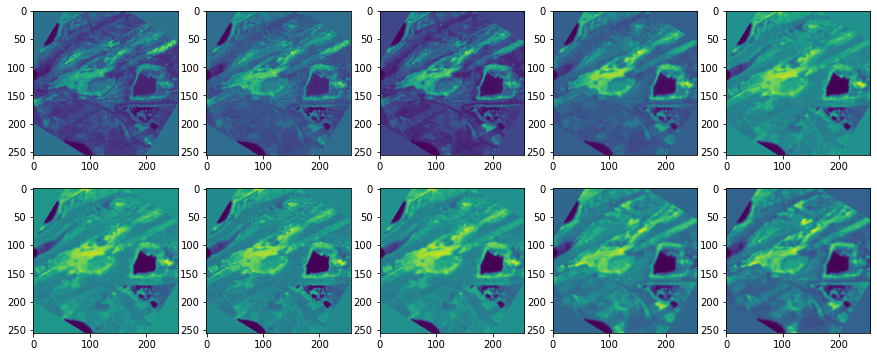

In [24]:
cols = 5
rows = 2
s = 3
fig, axes = plt.subplots(rows, cols, figsize=(s*cols, s*rows))
for img, ax in zip(imgs[0], axes.ravel()):
    ax.imshow(img.numpy())

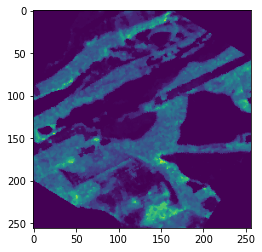

In [25]:
# Show ground truth
plt.imshow(labels[0][0].numpy())

### Define the model and the training pipeline

In [26]:
class Sentinel2Model(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = F.mse_loss(y_hat, y)
        self.log("train/loss", loss)
        self.log("train/rmse", torch.sqrt(loss))
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = F.mse_loss(y_hat, y)
        self.log("valid_loss", loss)
        self.log("valid_rmse", torch.sqrt(loss))
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.02)
    
    def forward(self, x):
        return self.model(x)

In [27]:
base_model = smp.Unet(
    encoder_name="resnet50",       
    in_channels=10,                 
    classes=1,                     
)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [28]:
# !wget https://zenodo.org/record/5610000/files/resnet50-sentinel2.pt

In [29]:
# base_model.encoder.load_state_dict(torch.load("resnet50-sentinel2.pt"))
s2_model = Sentinel2Model(base_model)

In [30]:
wandb_logger = WandbLogger(project='BioMassters_baseline')

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: amedyukh. Use `wandb login --relogin` to force relogin


In [31]:
 checkpoint_callback = ModelCheckpoint(
     monitor='valid_rmse',
     dirpath=os.path.join(model_checkpoint_path, wandb.run.name),
     filename='{epoch:02d}-{valid_rmse:.2f}')

In [32]:
# Initialize a trainer
trainer = Trainer(
    accelerator="gpu",
    max_epochs=20,
    logger=[wandb_logger],
    callbacks=[checkpoint_callback],
    log_every_n_steps=5
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


### Train

In [33]:
%%time
# Train the model ⚡
torch.random.manual_seed(42)
trainer.fit(s2_model, train_dataloaders=train_dataloader, 
            val_dataloaders=valid_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type | Params
-------------------------------
0 | model | Unet | 32.5 M
-------------------------------
32.5 M    Trainable params
0         Non-trainable params
32.5 M    Total params
130.172   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


CPU times: user 2min 22s, sys: 1min 59s, total: 4min 22s
Wall time: 34min 56s


### Show example predictions

In [34]:
s2_model.cuda();

In [35]:
imgs, labels = next(iter(train_dataloader))
pred = s2_model(imgs.cuda())

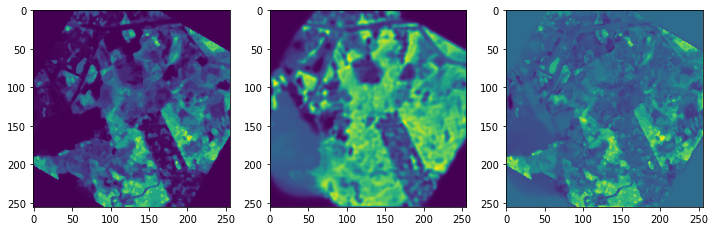

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(ndimage.median_filter(labels[0].numpy()[0], 3))
axes[1].imshow(pred[0].cpu().detach().numpy()[0])
axes[2].imshow(ndimage.median_filter(labels[0].numpy()[0], 3) - pred[0].cpu().detach().numpy()[0])

### Prediction

In [37]:
# os.makedirs(output_dir, exist_ok=True)
# s2_model.cuda();
# for chip_id in tqdm(pred_ids):
#     image = get_image(os.path.join(test_img_dir, 
#                                    rf"{chip_id}_S2_10.tif"))
#     image = torch.tensor(image.astype(np.float32)[:10])
#     image = (image - 
#               torch.tensor(MEANS).unsqueeze(1).unsqueeze(1))/torch.tensor(STDS).unsqueeze(1).unsqueeze(1)

#     pred = s2_model(image.unsqueeze(0).cuda())
#     im = Image.fromarray(pred.squeeze().cpu().detach().numpy())
#     im.save(f"{output_dir}/{chip_id}_agbm.tif", format="TIFF", save_all=True)

In [38]:
# shutil.make_archive('submission', 'zip', output_dir)

In [39]:
# from google.colab import files
# files.download('submission.zip')